In [4]:
%load_ext autoreload
%autoreload 2
import copy
import h5py
import xarray as xr

import sys
sys.path.append('/Users/angus/work/Omphalos')
import coeus

from coeus import plots


# Path to your HDF5 file
file_path = '/Users/angus/work/hydrothermal_alteration/pflotran_model/no_trans_model.h5'

# Open the HDF5 file as an xarray dataset
dataset = xr.open_dataset(file_path, group='Coordinates', phony_dims='sort', engine="h5netcdf")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
f = h5py.File(file_path, 'r')

In [6]:
def split_units(string):
    import re

    pattern = r'^(.*?)\s*(\[[^\[\]]+\])$'

    result = re.match(pattern, string)
    try:
        variable = result.group(1)
        unit = result.group(2)
    except AttributeError:
        variable = string
        unit = '-'

    return variable, unit

def extract_numbers(arr):
    import re
    numbers = []
    pattern = r'[-+]?\d*\.\d+E[-+]?\d+|\d+E[-+]?\d+|\d*\.\d+|\d+'  # regex pattern for scientific notation

    for string in arr:
        match = re.search(pattern, string)
        if match:
            numbers.append(float(match.group()))

    return numbers


def h5_to_xarray(file):
    """ Method to convert h5 file to xarray. Specific to PFLOTRAN output.
    :param file: h5 file object
    :return: xarray.DataArray 
    """
    import copy
    import xarray as xr
    try:
        file['Provenance']['PFLOTRAN']
    except KeyError:
        print("Are you this is a PFLOTRAN file?")

    # Get keys for time snapshots
    keys = file.keys()
    values_to_remove = ['Coordinates', 'Provenance']
    snapshot_keys = [x for x in keys if x not in values_to_remove]
    # Convert snapshot key names to time steps
    times = sorted(extract_numbers(snapshot_keys)) 
    
    # Get dataset shape
    time_dim_length = len(snapshot_keys)
    dim_lengths = {}
    # Match direction and dimension key from the file.
    # Done via and assumed order for now but could be improved to RegEx matching if required.
    dim_direction = dict(zip(['x','y','z'], list(file['Coordinates'].keys())))
    
    for direction in dim_direction:
       dim_lengths.update({direction: len(file['Coordinates'][dim_direction[direction]]) - 1})
    dim_lengths.update({'time': len(snapshot_keys)})
    
    da = xr.DataArray()
    # Add dimensions
    da = da.expand_dims(dim=dim_lengths)
    # Add coordinates 
    # Need to convert to 'point' rather than block format, so must get offset array
    # Assume grid is regular
    coordinates_dict = {}
    coord_units_dict = {}
    for coord in dim_direction:
        # Since grid is regular, remove last element and offset values by 1/2 interval
        arr = file['Coordinates'][dim_direction[coord]][:]
        grid_step = arr[1] - arr[0]
        arr = arr[:-1]
        arr = arr + grid_step/2
        # Split direction name and units before assignment
        dir_name, units = split_units(dim_direction[coord])
        coordinates_dict.update({dir_name: (coord, arr)})
        coord_units_dict.update({dir_name: units})
    # Assign coordinates to dimensions 
    da = da.assign_coords(coordinates_dict)
    da = da.assign_coords(time = ('time', times))
    for coord in coord_units_dict:
        da.coords[coord].attrs['units'] = coord_units_dict[coord]
    # Time unit is last letter in time index key string
    da.coords['time'].attrs['units'] = snapshot_keys[0][-1]

    ds = xr.Dataset()
    # Now dimensionality and coordinates have been constructed, populate with data
    for variable in file[snapshot_keys[0]].keys():
        name, unit = split_units(variable)
        da_var = copy.deepcopy(da)
        for i, time in enumerate(snapshot_keys):
            da_var[:,:,:,i] = file[snapshot_keys[i]][variable]
            da_var.attrs['units'] = unit
        ds[name] = da_var
        
    return ds

In [7]:
data = h5_to_xarray(f)

In [8]:
data

<xarray.Dataset>
Dimensions:            (x: 25, y: 1, z: 50, time: 2)
Coordinates:
    X                  (x) float64 20.0 60.0 100.0 140.0 ... 900.0 940.0 980.0
    Y                  (y) float64 50.0
    Z                  (z) float64 15.0 45.0 75.0 ... 1.455e+03 1.485e+03
  * time               (time) float64 0.0 0.0
Dimensions without coordinates: x, y, z
Data variables:
    Liquid X-Velocity  (x, y, z, time) float64 0.0 0.0 0.0 ... 0.0 0.0
    Liquid Y-Velocity  (x, y, z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Liquid Z-Velocity  (x, y, z, time) float64 0.0 0.002922 ... 0.0 2.723e+07
    Liquid_Density     (x, y, z, time) float64 533.2 533.2 ... 0.0002641
    Liquid_Pressure    (x, y, z, time) float64 3.829e+07 3.829e+07 ... 2.506e+07
    Material_ID        (x, y, z, time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Mineral_Porosity   (x, y, z, time) float64 0.01 0.01 0.01 ... 0.01 0.01 0.01
    Permeability       (x, y, z, time) float64 1.8e-15 1.8e-15 ... 1.8e-15
    Temperature        (x, y, z, time) float64 394.6 394.6 ... -191.3 -191.0

In [10]:
data.isel(z=99,x=49)['Material_ID']

<xarray.DataArray 'Material_ID' (y: 1, time: 2)>
array([[1., 1.]])
Coordinates:
    X        float64 495.0
    Y        (y) float64 5.0
    Z        float64 995.0
  * time     (time) float64 0.0 0.1126
Dimensions without coordinates: y
Attributes:
    units:    -

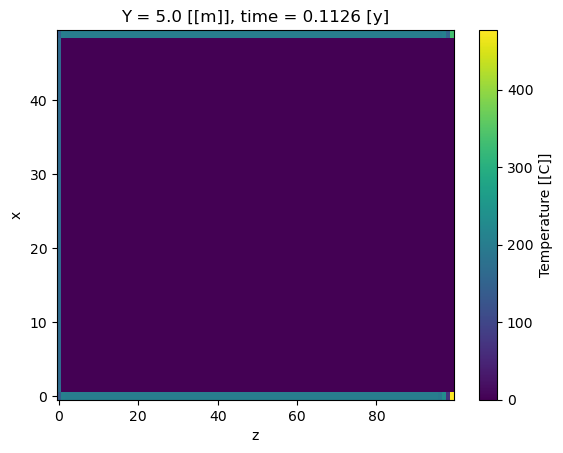

In [6]:
data[('Temperature')].isel(time=1).plot()

In [7]:
import figures
data = figures.synthetic_vars(data)

KeyError: 'Saponite-Mg_VF'

In [ ]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
import string
from cmcrameri import cm
import numpy as np
from figures import font_properties

font_props = font_properties()

time_steps = 71
fontsize = 24

fig, axes = plt.subplots(1,2, figsize=(14,15))
axis=axes[0]

plot_vars = ['amph', 'Clays', 'epidote', 'Anhydrite_VF', 'Calcite_VF', 'Hematite_VF']
categories= ['volume'] * len(plot_vars)

labels = {'amph': 'Secondary\nAmphibole', 'Clays': 'Clays', 'epidote': 'Epidote', 'Anhydrite_VF': 'Anhydrite', 'Calcite_VF': 'Calcite', 'Hematite_VF': 'Iron Oxides'}

log10 = 0

time = 9


j=0

#Prep fig before plotting
plots.format_axis(axis, font_props, category='volume', plot_var='Mineral volume', column=True)

# Line set loop (i.e. groups of lines sharing a property)
# Line instance loop

plot_indxs = [0,1,2,3,4,5]
i = 4 # Base case
i = 7 # Base case
for category, plot_var in zip(categories, plot_vars):
    try:
        x = data.isel(time=time, y=0, z=0)[plot_var].values
        y = data.isel(y=0, z=0).isel(time=time)['x'].values
    except IndexError:
        x=0
        y=0

    props = mpl.font_manager.FontProperties(weight='bold', size=20)
    axis.plot(x, y, label=f'{labels[plot_var]}')
    axis.legend(title='Mineral', prop=props, title_fontproperties=props)
    axis.text(-0.25, 1.05, '({})'.format(string.ascii_uppercase[0]), transform=axis.transAxes, size=28, weight='bold')

fig.tight_layout()

#axis.set_xscale('log')
#axis.set_xlim(1e-5, 1)


In [ ]:
axis = axes[1]
plot_vars = ['Basalt', 'Fayalite_VF', 'Albite_VF']
categories= ['volume'] * len(plot_vars)

labels = {'Basalt': 'Basalt', 'Fayalite_VF': 'Fayalite', 'Albite_VF': 'Albite', 'Forsterite_VF': 'Forsterite'}

#Prep fig before plotting
plots.format_axis(axis, font_props, category='volume', plot_var='Basalt', column=True)

# Line set loop (i.e. groups of lines sharing a property)
# Line instance loop

plot_indxs = [0,1,2,3,4,5]
i = 4 # Base case
for category, plot_var in zip(categories, plot_vars):
    try:
        x = data.isel(time=time, y=0, z=0)[plot_var].values
        y = data.isel(time=time, y=0, z=0)['x'].values
    except IndexError:
        x=0
        y=0

    axis.plot(x, y, c='k', label=f'{labels[plot_var]}')
    axis.legend(prop=props, title_fontproperties=props)
    axis.text(-0.25, 1.05, '({})'.format(string.ascii_uppercase[1]), transform=axis.transAxes, size=28, weight='bold')

fig.tight_layout()


fig.savefig(f'output/mineralogy.png', dpi=300)
fig.show()
